### Setup

In [19]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.linear_model import ElasticNetCV, LinearRegression, Lars
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from vb_helper import VBHelper

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

DATA UPLOAD
- user uploads data
   - calculate n,k
   - calculate sparsity of y
   - calculate missing values of x by column
   - calcualte missing values of x by row
   - calculate n if rows with missing vals dropped
   - calculate rank of resulting matrix (k_drop_r)
   
- Train/test split






In [3]:
test_share=0.2 
cv_folds=10
cv_reps=3
cv_count=cv_folds*cv_reps
rs=1 # random_state for reproducibility
vbhelper=VBHelper(test_share,cv_folds,cv_reps,cv_count,rs)

##### Example Dataset

In [30]:
X, y, w = make_regression(n_samples=30,
                          n_features=50, # x variables generated and returned 
                          n_informative=3, # x variables included in the actual model of y
                          effective_rank=2, # make less than n_informative for multicollinearity
                          coef=True,
                          noise=1,
                          random_state=rs,
                          bias=0.5)
#y=y*np.sin(y)
y=np.exp(y/100)

In [5]:
# add interaction terms

In [32]:
if test_share:
     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_share, random_state=rs)
else:
    X_train, X_test, y_train, y_test = (X, None, y, None)

In [33]:
n=X_train.shape[0]
max_k=n//4
vbhelper.max_k=max_k

## Model Selection
### define estimators
#### example:
 - make_pipeline(
   - handle missing values,
     - global: drop_rows or impute 
       - could also look for columns with many missing vals first
     - set cv_drop_rows variable if rows are dropped to make sure GBR doesn't use those in cross validation
   
   - make transformed columns,
   - Multi CV (make our own wrapper that chooses the best of model variations)
     - modify model (e.g., transform Y)
       - combined selection/estimation (e.g., lars(https://scikit-learn.org/stable/modules/linear_model.html#least-angle-regression))
       - pre-select-features -> CV estimate
         - for lin reg with k>n, 
           - select features k << n
           - project data such that k << n
   - set final model as best in the pipeline based on chosen loss (mse default for continuous y)
   
   

   


In [34]:
linear_regression_select=Pipeline(steps=[('scaler',StandardScaler()),('Lars',Lars(n_nonzero_coefs=max_k))])
linear_regression_select.fit(X_train,y_train)
print(linear_regression_select['Lars'].coef_)
a=mean_squared_error(linear_regression_select.predict(X_test),y_test)
a


[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.00391839
  0.          0.          0.01541096  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.02075746  0.          0.          0.          0.
  0.02692732  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.00165701 -0.00168925]


0.00020715510897624872

In [17]:
# use lambda to make a callable object for creating new models, but with args set already

linear_regression=lambda: make_pipeline(StandardScaler(),LinearRegression(fit_intercept=False)) # lambda so args,kwargs can be specified now rather than later
elastic_net =lambda: make_pipeline(StandardScaler(), ElasticNetCV(fit_intercept=False))
linear_svr =lambda: make_pipeline(StandardScaler(),LinearSVR(random_state=rs,tol=1e-4,max_iter=5000,C=1))
rbf_svr=lambda: make_pipeline(StandardScaler(),SVR(kernel='rbf',tol=1e-4,max_iter=5000, C=1))
gradient_boosting_reg=lambda: make_pipeline(GradientBoostingRegressor())

g_pts=3 # grid points for gridsearchcv param_grid
linear_svr = Pipeline(steps=[('scaler',StandardScaler()),('lin_svr',LinearSVR(random_state=0,tol=1e-4,max_iter=10000))])
lin_svr_param_grid={'lin_svr__C':np.logspace(-2,2,g_pts)}
linear_svr_cv=lambda: GridSearchCV(linear_svr,param_grid=lin_svr_param_grid)

rbf_svr=Pipeline(steps=[('scaler',StandardScaler()),('rbf_svr',SVR(kernel='rbf',tol=1e-4,max_iter=10000, cache_size=2*10**3))])
rbf_svr_param_grid={'rbf_svr__C':np.logspace(-2,2,g_pts),'rbf_svr__gamma':np.logspace(-1,0.5,g_pts)} 
rbf_svr_cv=lambda: GridSearchCV(rbf_svr,param_grid=rbf_svr_param_grid)


estimator_dict={'linear-regression':linear_regression,
            'elastic-net':elastic_net, 
            'linear-svr-cv':linear_svr_cv, 
            'rbf-svr-cv':rbf_svr_cv, 
            'gradient-boosting-reg':gradient_boosting_reg}

model_dict={key:val() for key,val in estimator_dict.items()} # they will be models once .fit is called

In [8]:
scorer_list=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'] #cross_validate wants strings
cv=RepeatedKFold(n_splits=cv_folds, n_repeats=cv_reps, random_state=rs) # define separately to ensure same cv data used for each model
vbhelper.scorer_list=scorer_list
# allow/generate water quality thresholds for stratified kfold sub-sampling to ensure cross-validation folds have full range of water quality

In [9]:
cv_results={estimator_name:cross_validate(model, X_train, y_train, return_estimator=True, scoring=scorer_list, cv=cv)
            for estimator_name,model in model_dict.items()}
# replace with a loop in order to save the residuals for a graph?

### graphs and table to summarize results

In [10]:
cv_score_dict={}
cv_score_dict_means={}
for idx,(estimator_name,result) in enumerate(cv_results.items()):
    #cv_estimators=result['estimator']
    model_idx_scoredict={scorer:result[f'test_{scorer}'] for scorer in scorer_list}# fstring bc how cross_validate stores list of metrics
    cv_score_dict[estimator_name]=model_idx_scoredict 
    model_idx_mean_scores={scorer:np.mean(scores) for scorer,scores in model_idx_scoredict.items()}
    cv_score_dict_means[estimator_name]=model_idx_mean_scores

In [11]:
for scorer in scorer_list:
    print(f'scores for scorer: {scorer}:')
    for estimator_name in model_dict:
        print(f'    {estimator_name}:{cv_score_dict_means[estimator_name][scorer]}')

scores for scorer: neg_mean_squared_error:
    linear-regression:-0.0007053089927900184
    elastic-net:-0.0006610013109169051
    linear-svr-cv:-0.000718884886134217
    rbf-svr-cv:-0.010569331663216698
    gradient-boosting-reg:-0.00717507440915885
scores for scorer: neg_mean_absolute_error:
    linear-regression:-0.019348160144413384
    elastic-net:-0.018300848859346006
    linear-svr-cv:-0.01961488877022578
    rbf-svr-cv:-0.0659375961662311
    gradient-boosting-reg:-0.050993902406307925
scores for scorer: r2:
    linear-regression:0.4450132922790092
    elastic-net:0.49067088347806653
    linear-svr-cv:0.49654399227005563
    rbf-svr-cv:-3.945120839374657
    gradient-boosting-reg:-2.1657496198215322


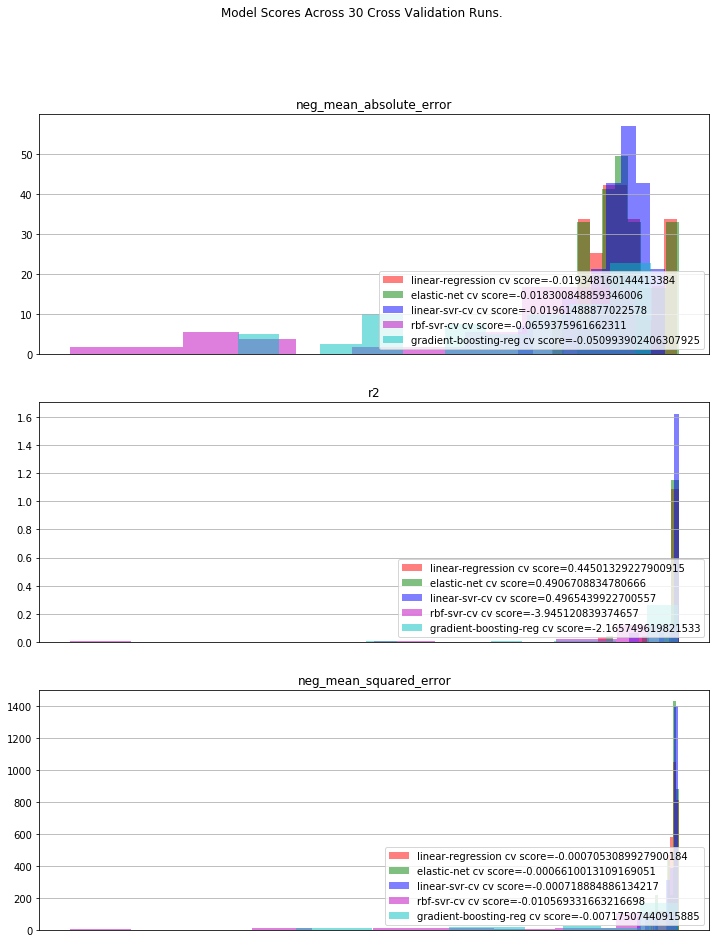

In [12]:
vbhelper.plotCVScores(cv_score_dict,sort=1)

In [13]:
# create a similar plot showing residuals from the cv models for each value of y. 
# needs to be scatterplot or histogram since there will be (folds-1)*repeats predictions of each value of y.

-----------------------------
### User chooses elastic net!


In [14]:
final_estimator_name='elastic-net'

In [15]:
vbhelper.printTestandCVScores(final_estimator_name,cv_score_dict_means)

NameError: name 'estimator_dict' is not defined

In [ ]:
printTestandCVScores('linear-regression')

## Next Steps
- ### add options for dealing with important but underrepresented values of Y
- ### construct model averaging using average cross validation scores
- ### predict with confidence intervals 
  -    #### could use variability from cv
  -   #### some algorithms have their own method
